# CCNSS 2019 - Large-Scale Network Model

*Please execute the cell bellow in order to initialize the notebook environment*

In [1]:
%matplotlib inline
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython.display import Image
#import pylab
import math
#import itertools
#pylab.rcParams['savefig.dpi'] = 150

** Purpose of tutorial **

Explore the dynamic mean-field model for large-scale resting state networks.

# Model Description

Consider $N$ excitatory neural assemblies with recurrent self-coupling $w$ and long range excitatory coupling $G$. 

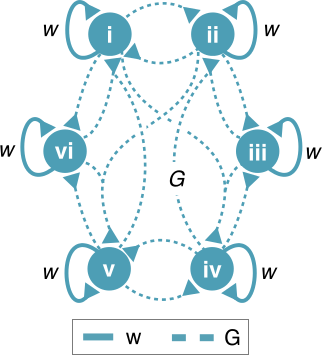

In [2]:
Image(filename='figures/model-scheme.png')

Let $r_i$ and $I_i$ be the population-firing rate and total synaptic input current for population $i\in\{1,\ldots,N\}$. The firing rate $r_i$ is determined by the transfer function $F(I_i)$ given by:

\begin{align}
r_i = F(I_i) = \frac{aI_i - b}{1-\exp\left(-d\left(aI_i-b\right)\right)}
\end{align}

where $a$ = 270 Hz/nA, $b$ = 108 Hz, $d$ = 0.154 sec.

The net current $I_i$ into population $i$ is given by 

\begin{align}
I_i &= w J_N S_i + G J_N\sum_{j=1}^N C_{ij} S_j + I_{bi}
\end{align}

where $J_N = 0.2609$ is the overall excitatory strength. The coupling parameters $w$ and $G$ scale the strengths of local and long-range interactions, respectively.

$I_{bi}$ is the background input into population $i$, which has a mean ($I_0$) and a noise component described by an Ornstein-Uhlenbeck process:

\begin{align}
\tau_0\frac{dI_{bi}}{dt} &=-(I_{bi}-I_0)+\eta_i(t)\sqrt{\tau_0\sigma^2}
\end{align}

where $I_0=0.3255$ nA, filter time constant $\tau_0=2$ ms, and noise amplitude $\sigma=0.02$ nA; $\eta(t)$ is a Gaussian white-noise with zero mean and unit standard deviation.

Assume that the *synaptic drive variable* $S_i$ for population $i$ obeys:

\begin{align}
\frac{dS_i}{dt} &= F\left(I_i\right)\gamma\left(1-S_i\right)-\frac{1}{\tau_s}\,S_i
\end{align}

where synaptic time constant $\tau_s$ = 100 ms and $\gamma$ = 0.641.

The synaptic drive $S_i$ is very indicative of the level of activity in population $i$ at time $t$. High levels of activity require rapid delivery of oxigenated blood to neuronal tissues that is captured by the BOLD signal of fMRI. The BOLD signal $B_i(t)$ is tipically modeled as a delayed low-pass filtered version of $S_i(t)$. We'll use the Boynton gamma function as the filter kernel:

\begin{align}
f_{bold}(t)&=\left(\frac{t-o}{\tau_{bold}}\right)^{p-1}\,\frac{1}{(p-1)!}\,\exp\left(-\frac{t-o}{\tau_{bold}}\right) H(t-o)
\end{align}

where $p=2$ is a shape parameter, $\tau_{bold}=1.25$ s is a timescale parameter and $o=2.25$ s is a delay parameter and $H(t-o)$ is the Heaviside function.

The BOLD signal $B(t)$ generated by $S_i(t)$ is computed by evaluating the causal convolution of $S_i(t)$ with filter kernel $f_{bold}(t)$:

\begin{align}
B_i(t) &= \int_{-\infty}^t S_i(x)\,f_{bold}(t-x)\,dx
\end{align}

With the proposed parameters the kernel $f_{bold}(t)$ is simply a gamma function starting at $t=o$:

\begin{align}
B_i(t) = \int_{-\infty}^{t-o} S_i(x) \,\frac{t-o-x}{\tau_{bold}}\,\exp\left(-\frac{t-o-x}{\tau_{bold}}\right) dx
\end{align}

The Global Signal (GS) is the average BOLD signal:

\begin{align}
GS(t) &= \frac{1}{N}\sum_{i=1}^N B_i(t)
\end{align}

** Time Averages **

**References**
* Deco, G., Ponce-Alvarez, A., Mantini, D., Romani, G. L., Hagmann, P., & Corbetta, M. (2013). <a href="resources/2012.deco.jn.pdf"> Resting-state functional connectivity emerges from structurally and dynamically shaped slow linear fluctuations</a>. The Journal of Neuroscience, 33(27), 11239-11252.
* Yang, G. J., Murray, J. D., Repovs, G., Cole, M. W., Savic, A., Glasser, M. F., ... & Anticevic, A. (2014). <a href="resources/2014.yang.pnas.pdf">Altered global brain signal in schizophrenia</a>. Proceedings of the National Academy of Sciences, 111(20), 7438-7443.
* Anticevic, A., Gancsos, M., Murray, J. D., Repovs, G., Driesen, N. R., Ennis, D. J., ... & Corlett, P. R. (2012). ,<a href="resources/2012.anticevic.pnas.pdf">NMDA receptor function in large-scale anticorrelated neural systems with implications for cognition and schizophrenia</a>. Proceedings of the National Academy of Sciences, 109(41), 16720-16725.
* Wong K-F and Wang X-J (2006) A recurrent network mechanism for time integration in perceptual decisions. J. Neurosci 26, 1314-1328.

We first import the structural connectivity matrix. Note the sparse connectivity between brain areas.

(66, 66) (66, 66)


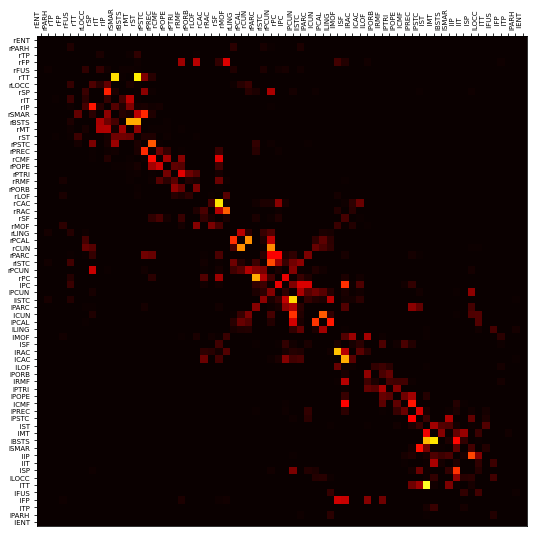

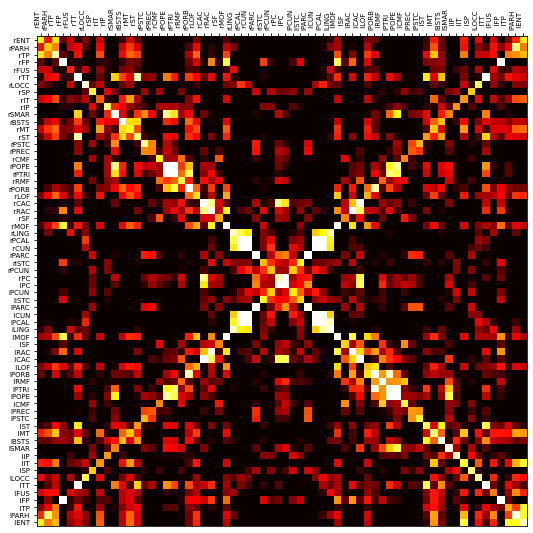

In [3]:
# import structural connectivity and functional connectivity data
load_path = 'data/Human_66.mat'
load_data = sio.loadmat(load_path)
C, anat_labels, FC, order = np.array(load_data['C']), load_data['anat_lbls'],\
np.array(load_data['FC_emp']), np.array(load_data['Order'][0])-1

C = C[order,:]
C = C[:,order]

anat_labels = anat_labels[order]

FC = FC[order,:]
FC = FC[:,order]

print(C.shape, FC.shape)

# plot connectivity weights matrix

fig = plt.figure(figsize=(10, 10))
plt.imshow(C,interpolation='nearest',cmap='hot',vmin=0,vmax=.25)
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(np.arange(0, len(anat_labels), 1), anat_labels, size=7)
plt.yticks(np.arange(0, len(anat_labels), 1), anat_labels, size=7)
plt.show()

fig = plt.figure(figsize=(10, 10))
plt.imshow(FC,interpolation='nearest',cmap='hot',vmin=0,vmax=.25)
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(np.arange(0, len(anat_labels), 1), anat_labels, size=7)
plt.yticks(np.arange(0, len(anat_labels), 1), anat_labels, size=7)
plt.show()

Let's define the transfer function $F(I_i)$, the BOLD signal kernel $f_{bold}(t)$ and BOLD transformation:

In [4]:
def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

def fbold(t, p=2., taub=1.25, o=2.25):
    """fbold(t) kernel for vector t"""
    kernel  = np.zeros_like(t)
    idx = t >= o
    
    kernel[idx] = ((t[idx] - o)/taub)**(p-1) / math.factorial(p-1) * np.exp(-(t[idx] - o)/taub)
    
    return kernel

Let's define the simulation kernel:

In [5]:
def run_sim(pars, verbose=False):
    """S(t), r(t), Isyn(t), Ieta(t), b(t) for vector t"""
   
    # Retrieve parameters
    C = pars['C']
    N = pars['N']
    w, G = pars['w'], pars['G'] 
    JN = pars['JN']
    tauS, gamma = pars['tauS'], pars['gamma']
    I0, tau0, sigma = pars['I0'], pars['tau0'], pars['sigma']
    
    range_t = pars['range_t']
    nt = range_t.size
    dt = range_t[1] - range_t[0]
    
    # Initialize
    S = np.zeros([N, nt]);
    B = np.zeros([N, nt]);
    r = np.zeros([N, nt]);
    Isyn = np.zeros(N)#np.zeros([N, nt]);
    Ieta = np.zeros(N)#np.zeros([N, nt]);
    
    #seed = pars['seed']
    
    # Set random seed
    np.random.seed()
    
    # Initialize state variables
    #S[:, 0] = np.random.rand(N)
    S[:, 0] = 0. * np.ones(N)
    Ieta = I0 + sigma*np.random.randn(N)
    noise = np.random.randn(N,nt)
    
    if verbose:
        print ('Running...')
    for idx in range(1, nt):
    
        # Total synaptic input
        Isyn = w*JN*S[:, idx-1] + G*JN*np.dot(C, S[:, idx-1]) + Ieta
        
        # Transfer function to get firing rate
        r[:, idx]  = F(Isyn)
    
        #---- Dynamical equations -------------------------------------------

        # Update synaptic dynamics
        S[:, idx] = S[:, idx-1] + dt*(-S[:, idx-1]/tauS + (1-S[:, idx-1])*gamma*r[:, idx])
    
        # Update Ornstein-Uhlenbeck process
        Ieta = Ieta + (dt/tau0)*(I0-Ieta) + np.sqrt(dt/tau0)*sigma*noise[:,idx]
    
    # Extract BOLD signal
    fbold_vec = fbold(range_t)
    for idx in range(N):
        B[idx] = np.convolve(S[idx], fbold_vec)[:nt]
    if verbose:
        print('done!')
    z = {'S':S, 'r':r, 'Isyn': Isyn, 'Ieta':Ieta, 'B': B}
    return z

Here we define some default parameters for the network and simulation, which can be changed later:

In [6]:
def default_pars(C, **kwargs):
    pars = {}
    ### Network Parameters ###
    pars['C'] = C # structural connectivity
    pars['w'] = 0.55 # self-excitation scaling factor
    pars['G'] = 3.5 # long-range scaling factor
    pars['JN'] = 0.2609 # overall excitatory strength [nA]
    pars['I0'] = 0.3#0.3255 # background current [nA]
    pars['tauS'] = 0.1 # Synaptic time constant [sec]
    pars['gamma'] = 0.641 # Saturation factor for gating variable
    pars['tau0'] = 0.002 # Noise time constant [sec]
    pars['sigma'] = 0.005 # Noise magnitude [nA]
    ### Simulation Parameters ###
    pars['N'] = C.shape[0] # number of nodes
    pars['T'] = 20.  # Total duration of simulation [sec]
    pars['dt'] = 0.001 # Simulation time step [sec]
    #pars['S_init'] = 0.0 * np.ones(C.shape[0]) # initial value for S
    
    for k in kwargs:
        pars[k] = kwargs[k]
    
    pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of time points 
        
    return pars


# Part 0: Testing things out

_Note: For comptuational expediency in this tutorial, we will focus on the dynamics of synaptic gating variables $(S)$ rather than BOLD signals $(B)$._

**1.** Simulate the model with default values. Plot the time course of $S$ for all nodes. Remove the intial part of the time course for $S$ which is the intial transient as $S$ approaches baseline values.

_Note: The system coexist low and high-activity states, two fixed points_

In [7]:
pars = default_pars(C)
#pars['S_init'] *=  1.0*np.random.rand(C.shape[0])
res = run_sim(pars)

/var/folders/gd/drx9n0_j0c7fpqn40bw90kknxnq3n6/T/ipykernel_75283/2926505573.py:11: DeprecationWarning: Using factorial() with floats is deprecated
  kernel[idx] = ((t[idx] - o)/taub)**(p-1) / math.factorial(p-1) * np.exp(-(t[idx] - o)/taub)


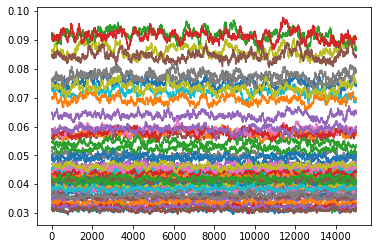

In [8]:
plt.plot(res['S'].T[5000:]);
plt.show()

**2.** Double the scaling of long-range coupling $G$. Now plot $S$ in time for all nodes. Did the low-activity baseline state destabilize? How could you test for instability of the baseline state?

In [9]:
pars = default_pars(C)
pars['G'] *= 2.
print (pars['G'])
res = run_sim(pars)

7.0


/var/folders/gd/drx9n0_j0c7fpqn40bw90kknxnq3n6/T/ipykernel_75283/2926505573.py:11: DeprecationWarning: Using factorial() with floats is deprecated
  kernel[idx] = ((t[idx] - o)/taub)**(p-1) / math.factorial(p-1) * np.exp(-(t[idx] - o)/taub)


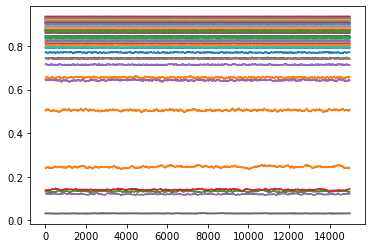

In [10]:
plt.plot(res['S'].T[5000:]);

In [11]:
pars = default_pars(C, T=1)
pars['G'] *= 2
res = run_sim(pars)

/var/folders/gd/drx9n0_j0c7fpqn40bw90kknxnq3n6/T/ipykernel_75283/2926505573.py:11: DeprecationWarning: Using factorial() with floats is deprecated
  kernel[idx] = ((t[idx] - o)/taub)**(p-1) / math.factorial(p-1) * np.exp(-(t[idx] - o)/taub)


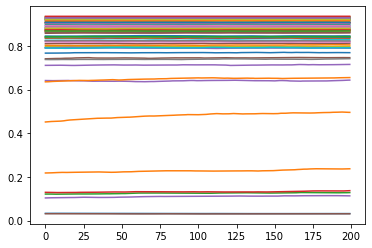

In [12]:
plt.plot(res['S'].T[800:]);

/var/folders/gd/drx9n0_j0c7fpqn40bw90kknxnq3n6/T/ipykernel_75283/2926505573.py:11: DeprecationWarning: Using factorial() with floats is deprecated
  kernel[idx] = ((t[idx] - o)/taub)**(p-1) / math.factorial(p-1) * np.exp(-(t[idx] - o)/taub)


Text(0, 0.5, 'max S')

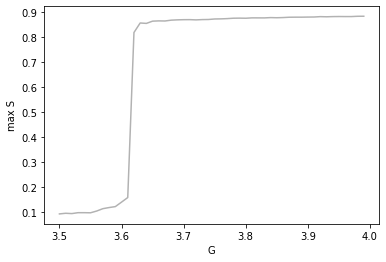

In [13]:
Gs = np.arange(3.5,4,.01)
lastSs = []
for G in Gs:
    pars = default_pars(C, T=4)
    pars['G'] = G
    res = run_sim(pars)
    lastSs.append(res['S'][:,-1].max())
plt.plot(Gs,lastSs, 'k', alpha=0.3)
plt.xlabel('G')
plt.ylabel('max S')

# Part 1: Functional Connectivity vs Structural Connectivity

_Note: Ideally we would calculate all metrics using BOLD ($B$). However, due to the sluggishness of the BOLD response, we will first use the synaptic gating variables ($S$) as our measure of neural activity._

**1.**  Generate and show the functional connectivity (FC) matrix from the neural signal (S).

In [14]:
pars = default_pars(C, T=10)
pars['G'] = 3.5
res = run_sim(pars)

/var/folders/gd/drx9n0_j0c7fpqn40bw90kknxnq3n6/T/ipykernel_75283/2926505573.py:11: DeprecationWarning: Using factorial() with floats is deprecated
  kernel[idx] = ((t[idx] - o)/taub)**(p-1) / math.factorial(p-1) * np.exp(-(t[idx] - o)/taub)


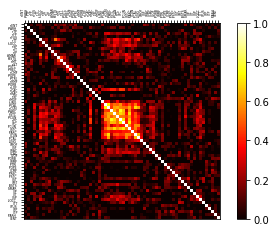

In [15]:
FCsim = np.corrcoef(res['S'][:,1000:])
plt.imshow(FCsim,interpolation='nearest',cmap='hot', vmin=0, vmax=1)
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(np.arange(0, len(anat_labels), 1), anat_labels, size=3)
plt.yticks(np.arange(0, len(anat_labels), 1), anat_labels, size=3)
plt.colorbar()

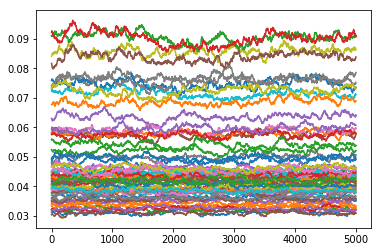

In [16]:
plt.plot(res['S'].T[5000:]);

**2.** Measure the correlation between FC and SC matrices.

In [17]:
np.corrcoef(C.ravel(), FCsim.ravel())[0,1]

0.20763359937293988

**3.** Investigate the eigenvectors of FC and SC matrices. What do the dominant eigenvectors look like?

In [18]:
def srtedEig(M):
    ew, ev = np.linalg.eig(M)
    srtidx = np.argsort(ew)[::-1]
    ew = ew[srtidx]
    ev = ev[:,srtidx]
    return ew, ev

ewSC, evSC = srtedEig(C)
ewFCsim, evFCsim = srtedEig(FCsim)
ewFC, evFC = srtedEig(FC)

In [19]:
a=np.random.rand(10)
print(a)
print(np.argsort(a))
print(np.argsort(a)[::-1])

[0.7970987  0.04958269 0.1475605  0.39694228 0.05074565 0.61416462
 0.62941914 0.38157555 0.93608038 0.24860485]
[1 4 2 9 7 3 5 6 0 8]
[8 0 6 5 3 7 9 2 4 1]


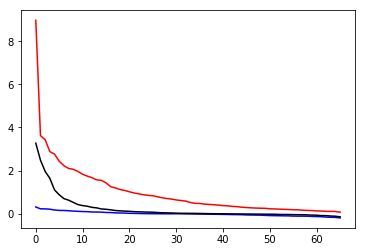

In [20]:
plt.plot(ewSC,'b')
plt.plot(ewFC,'k')
plt.plot(ewFCsim,'r')

In [22]:
#print (anat_labels)
id_lPC = np.argwhere(anat_labels == u'  lPC')[0][0]

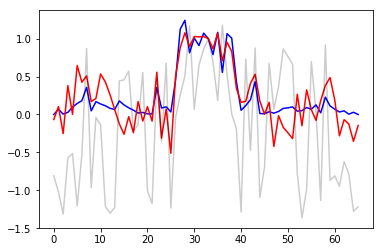

In [29]:
id_eig = 0


#print (ewFCsim[0])
plt.plot(evSC[:,id_eig]/evSC[id_lPC,id_eig],'b')
plt.plot(evFCsim[:,id_eig]/evFCsim[id_lPC,id_eig],'r')
plt.plot(evFC[:,id_eig]/evFC[id_lPC,id_eig],'k', alpha =0.2)
plt.show()

# Part 2: Parameter Space Exploration

**1.** Do a 1-dimensional parameter sweep, first through $G$ and then $w$, characterize in terms of the following metrics:

* Correlation between FC and SC
* Mean local variance Mean($\text{Var}(S_i))$
* Global Signal variance $\text{Var}(GS)$
* Boundary of stability in parameter space (instable if at least one $S_i\geq S_{th}$).

What do you find?

In [24]:
def corrcoefWithoutDiag(A,B):
    n = A.shape[0]
    vec = [(A[i,j], B[i,j]) for i,j in itertools.product(range(n),range(n)) if i!=j]
    return np.corrcoef(np.array(vec).T)[0,1]

In [28]:
%timeit corrcoefWithoutDiag(C, FCsim)

100 loops, best of 3: 3.78 ms per loop


In [29]:
%timeit corrcoefWithoutDiag(FC, FCsim)

100 loops, best of 3: 4.42 ms per loop


In [22]:
a = np.random.randn(3,3)
print (a)
ida = (np.eye(3) == 0)
print (a[ida].ravel())

[[-0.26030074  1.34080583 -0.79589064]
 [ 0.4003096   0.2751632   0.81460872]
 [ 1.27039621 -0.95418404 -0.15916903]]
[ 1.34080583 -0.79589064  0.4003096   0.81460872  1.27039621 -0.95418404]


In [31]:
def c2(A,B):
    idx = (np.eye(A.shape[0]) == 0)
    return np.corrcoef(A[idx], B[idx])[0,1]

In [33]:
%timeit c2(FC, FCsim) #corrcoefWithoutDiag(C, FCsim)

1000 loops, best of 3: 169 µs per loop


In [34]:
print (c2(FC, FCsim), corrcoefWithoutDiag(FC, FCsim))

(0.26234356208120685, 0.26234356208120685)


In [25]:
Gs = np.arange(1, 10, 1.)
ws = np.arange(0.3,1,0.1)

corrs1 = np.empty((len(Gs), len(ws)))
corrs2 = np.empty((len(Gs), len(ws)))
meanVars = np.empty((len(Gs), len(ws)))
globalSignalVars = np.empty((len(Gs), len(ws)))
Smaxs = np.empty((len(Gs), len(ws)))

for i,G in enumerate(Gs):
    for j,w in enumerate(ws):
        pars = default_pars(C, T=5)
        pars['G'] = G
        pars['w'] = w
        res = run_sim(pars)
        FCsim = np.corrcoef(res['S'][:,2500:])
        
        corrs1[i,j] = corrcoefWithoutDiag(FC_reorder, FCsim)
        corrs2[i,j] = corrcoefWithoutDiag(C, FCsim)
        meanVars[i,j] = res['S'].var(axis=1).mean()
        globalSignalVars[i,j] = res['S'].mean(axis=0).var()
        Smaxs[i,j] = res['S'][:,-1].max()
        

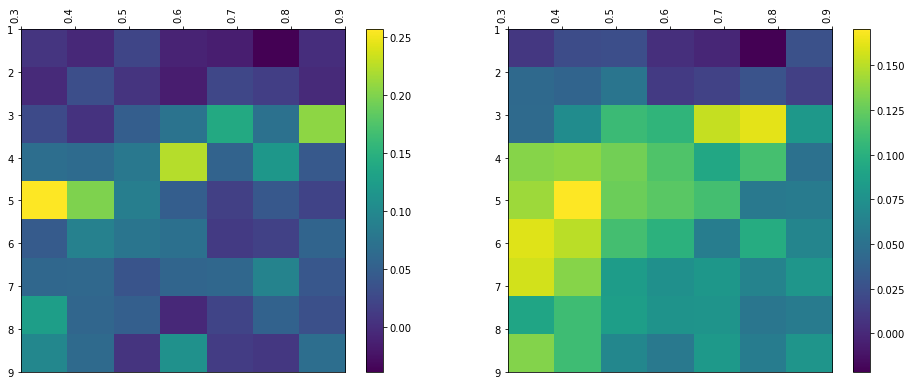

In [26]:
fig1 = plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.imshow(corrs1, interpolation='nearest',extent=(ws[0],ws[-1],Gs[-1],Gs[0]), aspect='auto')
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(ws)
plt.yticks(Gs)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(corrs2, interpolation='nearest',extent=(ws[0],ws[-1],Gs[-1],Gs[0]), aspect='auto')
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(ws)
plt.yticks(Gs)
plt.colorbar()

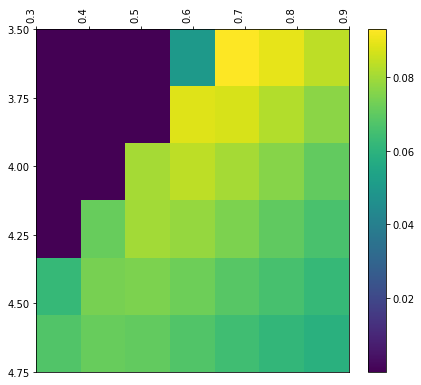

In [90]:
fig1 = plt.figure(figsize=(7,7))
plt.imshow(meanVars, interpolation='nearest',extent=(ws[0],ws[-1],Gs[-1],Gs[0]), aspect='auto')
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(ws)
plt.yticks(Gs)
plt.colorbar()

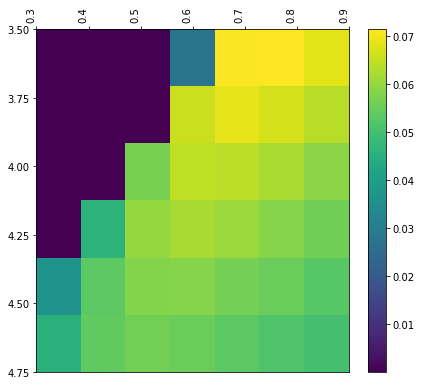

In [91]:
fig1 = plt.figure(figsize=(7,7))
plt.imshow(globalSignalVars, interpolation='nearest',extent=(ws[0],ws[-1],Gs[-1],Gs[0]), aspect='auto')
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(ws)
plt.yticks(Gs)
plt.colorbar()

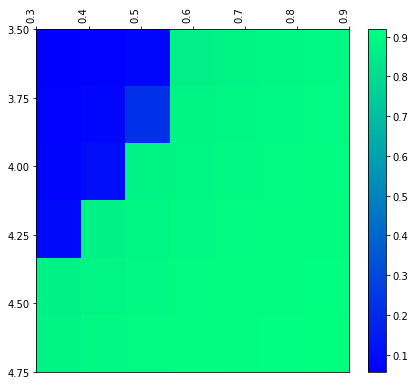

In [100]:
fig1 = plt.figure(figsize=(7,7))
plt.imshow(Smaxs, interpolation='nearest',extent=(ws[0],ws[-1],Gs[-1],Gs[0]), aspect='auto', cmap='winter')
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(ws)
plt.yticks(Gs)
plt.colorbar()

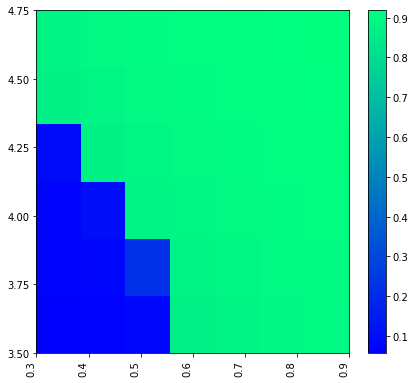

In [102]:
fig1 = plt.figure(figsize=(7,7))
plt.imshow(Smaxs, interpolation='nearest',extent=(ws[0],ws[-1],Gs[0],Gs[-1]), aspect='auto', cmap='winter', origin='lower')
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(ws)
plt.yticks(Gs)
plt.colorbar()

**2.** Sweep thorugh the 2-dimensional parameterspace of $\{G,w\}$ and characterize these metrics. 

_Note: 2-dimensional parameter sweeps can be computationally intensive, so choose your resolution appropriately._

# Part 3: Timescales

**1.** Compare and contrasts results using two neural signals: synaptic activity ($S$) vs. BOLD ($B$). In particular, does the choice of neural signal affect the pattern of FC and the correlation between FC and SC? 

_Note: To use the BOLD signal, you will need a longer simulation duration and longer duration of initial time to remove transients in BOLD._

In [103]:
pars = default_pars(C, T=50)
pars['G'] = 3.5
res = run_sim(pars)

('Correlation, FCsim of S: ', 0.39468968648971997)
('Correlation, FCsim of B: ', 0.1983905225171429)


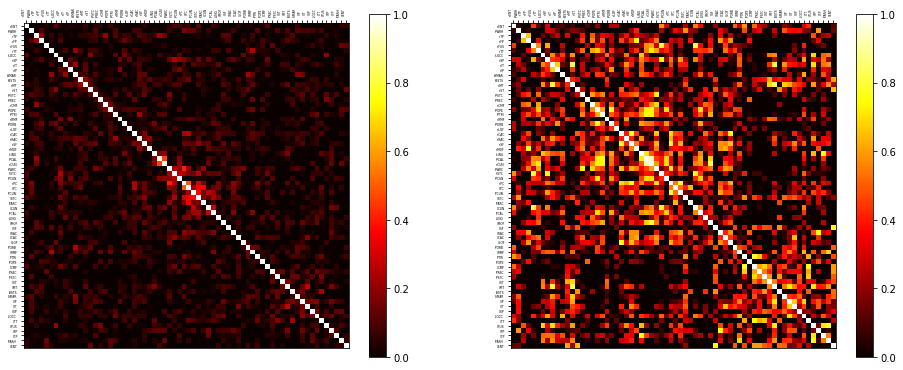

In [115]:
fig1 = plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
FCsim_S = np.corrcoef(res['S'][:,25000:])
print ('Correlation, FCsim of S: ',np.corrcoef(FC_reorder.ravel(), FCsim_S.ravel())[0,1])
plt.imshow(FCsim_S,interpolation='nearest',cmap='hot', vmin=0, vmax=1)
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(np.arange(0, len(anat_labels), 1), anat_labels, size=3)
plt.yticks(np.arange(0, len(anat_labels), 1), anat_labels, size=3)
plt.colorbar()

plt.subplot(1,2,2)
FCsim_B = np.corrcoef(res['B'][:,25000:])
print ('Correlation, FCsim of B: ',np.corrcoef(FC_reorder.ravel(), FCsim_B.ravel())[0,1])
plt.imshow(FCsim_B,interpolation='nearest',cmap='hot', vmin=0, vmax=1)
plt.gca().xaxis.tick_top()
plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(np.arange(0, len(anat_labels), 1), anat_labels, size=3)
plt.yticks(np.arange(0, len(anat_labels), 1), anat_labels, size=3)
plt.colorbar()

0.4423197627416458


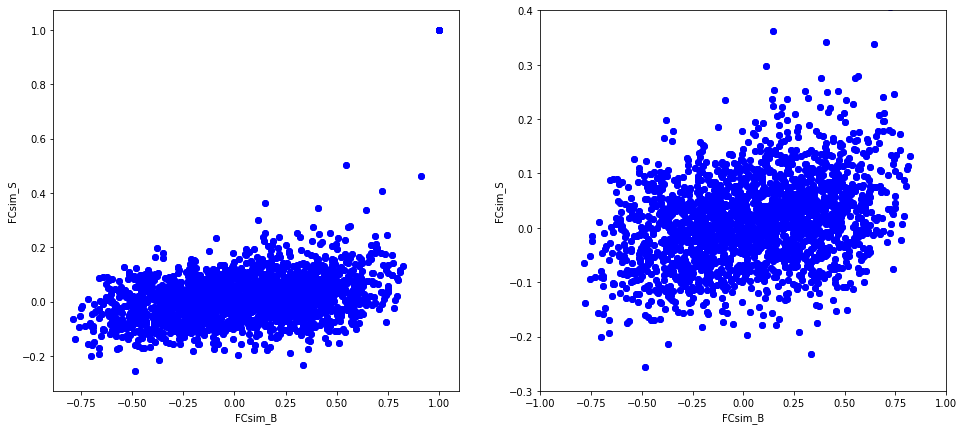

In [111]:
fig1 = plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(FCsim_B, FCsim_S, c='b')
plt.xlabel('FCsim_B')
plt.ylabel('FCsim_S')

plt.subplot(1,2,2)
plt.scatter(FCsim_B, FCsim_S, c='b')
plt.xlabel('FCsim_B')
plt.ylabel('FCsim_S')
plt.ylim(-0.3,0.4);
plt.xlim(-1.00,1.0);

print (np.corrcoef(FCsim_B.ravel(), FCsim_S.ravel())[0,1])